In [ ]:
# https://github.com/sismetanin/sentiment-analysis-of-tweets-in-russian/blob/master/Sentiment%20Analysis%20of%20Tweets%20in%20Russian%20using%20Convolutional%20Neural%20Networks.ipynb

### 1. Loading sentiment data

##### The corpus of short texts in Russian based on Twitter messages is available at http://study.mokoron.com/ (and also described in [1]). The files positive.csv
##### and negative.csv contain positively labelled and negatively labelled tweets, respectively.

In [2]:
import pandas as pd
import numpy as np

n = ['id', 'date', 'name', 'text', 'typr', 'rep', 'rtw', 'faw', 'stcount', 'foll', 'frien', 'listcount']
data_positive = pd.read_csv('positive.csv', sep=';', error_bad_lines=False, names=n, usecols=['text'])
data_negative = pd.read_csv('negative.csv', sep=';', error_bad_lines=False, names=n, usecols=['text'])

sample_size = min(data_positive.shape[0], data_negative.shape[0])
raw_data = np.concatenate((data_positive['text'].values[:sample_size],
                           data_negative['text'].values[:sample_size]), axis=0)
labels = [1] * sample_size + [0] * sample_size

In [3]:
import re

def preprocess_text(text):
    text = text.lower().replace("ё", "е")
    text = re.sub('((www\.[^\s]+)|(https?://[^\s]+))', 'URL', text)
    text = re.sub('@[^\s]+', 'USER', text)
    text = re.sub('[^a-zA-Zа-яА-Я1-9]+', ' ', text)
    text = re.sub(' +', ' ', text)
    return text.strip()


data = [preprocess_text(t) for t in raw_data]

In [5]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, random_state=2)

### 2. Defining metrics¶

##### Since Keras 2.0 metrics F-measure, precision, and recall have been removed, so the following code was found in the history of the repo.

In [8]:
from keras import backend as K


def precision(y_true, y_pred):
    """Precision metric.

    Only computes a batch-wise average of precision.

    Computes the precision, a metric for multi-label classification of
    how many selected items are relevant.
    """
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision


def recall(y_true, y_pred):
    """Recall metric.

    Only computes a batch-wise average of recall.

    Computes the recall, a metric for multi-label classification of
    how many relevant items are selected.
    """
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall


def f1(y_true, y_pred):
    def recall(y_true, y_pred):
        """Recall metric.

        Only computes a batch-wise average of recall.

        Computes the recall, a metric for multi-label classification of
        how many relevant items are selected.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

    def precision(y_true, y_pred):
        """Precision metric.

        Only computes a batch-wise average of precision.

        Computes the precision, a metric for multi-label classification of
        how many selected items are relevant.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision

    precision = precision(y_true, y_pred)
    recall = recall(y_true, y_pred)
    return 2 * ((precision * recall) / (precision + recall + K.epsilon()))

### 3. Preparing weights for the embedding layer

##### I used Word2Vec [] embeddings, which were obtained at the previous step. It's a computationally efficient model for learning word embeddings developed 
##### by Google. The detailed guide of prepearing the embedding layer is availbale at https://blog.keras.io/using-pre-trained-word-embeddings-in-a-keras-model.html

In [10]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

SENTENCE_LENGTH = 26
NUM = 100000

def get_sequences(tokenizer, x):
    sequences = tokenizer.texts_to_sequences(x)
    return pad_sequences(sequences, maxlen=SENTENCE_LENGTH)

tokenizer = Tokenizer(num_words=NUM)
tokenizer.fit_on_texts(x_train)

x_train_seq = get_sequences(tokenizer, x_train)
x_test_seq = get_sequences(tokenizer, x_test)

In [16]:
x_train[0]

'USER ахахах ну ты же стааарше меня мне нужна поддержка ты ж не против кому если не тебе'

In [22]:
str(sequences)

'[[3559], [833], [5622], [7880], [], [8], [135], [8], [135], [8], [135], [], [333], [13], [], [222], [3409], [], [180], [721], [], [11], [222], [8], [8], [8], [378], [1230], [721], [], [462], [721], [333], [3], [], [462], [333], [721], [], [333], [13], [180], [333], [8], [], [674], [33], [420], [420], [721], [378], [180], [40], [8], [], [222], [3409], [], [180], [], [333], [721], [], [674], [378], [33], [222], [4], [5], [], [40], [33], [462], [13], [], [721], [11], [504], [4], [], [333], [721], [], [222], [721], [256], [721]]'

In [12]:
x_train_seq[0]

array([    0,     0,     0,     0,     0,     0,     0,     0,     1,
         260,    23,    22,    29, 65895,    15,    19,   467,  4766,
          22,   180,     2,   690,   225,    49,     2,    50],
      dtype=int32)

### Create model for Word2vec

##### Download db.sql from http://study.mokoron.com/
##### Download script https://github.com/dumblob/mysql2sqlite 
##### cmod +x mysql2sqlite 
##### ./mysql2sqlite db.sql | sqlite3 mysqlite3.db

In [26]:
for row in c.execute('SELECT ttext FROM sentiment limit 10'):
    print(row[0])

Грустный суворовец с пятым айфоном.
RT @juvivenofara: ненавижу 10рублевый металл..  на неделе уже второй раз спутал с 50коп.. )-8 продавцы сознательные, и я не первый у них.
RT @tourskidki_ru: Тур во Вьетнам (Нячанг) на 7 ночей в отель Green 3* с 8 декабря от 25000 руб. (732$) #turskidki http://t.co/q0svXMA4uW
рппр
Добралась до ночлега, не хоромы, но переночевать можно. http://t.co/Yaccm9WoBy
http://t.co/s4pFwz4jPg зеленый кофе конголезский похудеть
http://t.co/uprIHas3AH решебник по математике 6 класс бевз бевз самостоятельная работа
 http://t.co/uprIHas3AH
Стоять бояться!
вставить лица в свадебный шаблон http://t.co/9XS1pal9mw
Если вместо лаваша шаурму завернуть в подорожник, то кот заживет и убежит.


In [27]:
import sqlite3

# Открываем SQLite базу данных
conn = sqlite3.connect('mysqlite3.db')
c = conn.cursor()

with open('tweets.txt', 'w', encoding='utf-8') as f:
    # Считываем тексты твитов 
    for row in c.execute('SELECT ttext FROM sentiment'):
        if row[0]:
            tweet = preprocess_text(row[0])
            # Записываем предобработанные твиты в файл
            print(tweet, file=f)

In [29]:
import logging
import multiprocessing
import gensim
from gensim.models import Word2Vec

logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)
# Считываем файл с предобработанными твитами
data = gensim.models.word2vec.LineSentence('tweets.txt')
# Обучаем модель 
model = Word2Vec(data, size=200, window=5, min_count=3, workers=multiprocessing.cpu_count())
model.save("model.w2v")

2021-03-10 12:48:54,918 : INFO : collecting all words and their counts
2021-03-10 12:48:54,918 : INFO : PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2021-03-10 12:48:54,962 : INFO : PROGRESS: at sentence #10000, processed 98345 words, keeping 24248 word types
2021-03-10 12:48:55,004 : INFO : PROGRESS: at sentence #20000, processed 194782 words, keeping 38847 word types
2021-03-10 12:48:55,046 : INFO : PROGRESS: at sentence #30000, processed 290743 words, keeping 50531 word types
2021-03-10 12:48:55,085 : INFO : PROGRESS: at sentence #40000, processed 386269 words, keeping 60653 word types
2021-03-10 12:48:55,123 : INFO : PROGRESS: at sentence #50000, processed 482755 words, keeping 69689 word types
2021-03-10 12:48:55,159 : INFO : PROGRESS: at sentence #60000, processed 578104 words, keeping 78235 word types
2021-03-10 12:48:55,195 : INFO : PROGRESS: at sentence #70000, processed 672686 words, keeping 85840 word types
2021-03-10 12:48:55,237 : INFO : PROGRESS: at s

In [75]:
y_testensim.models import Word2Vec
# Загружаем обученную модель
w2v_model = Word2Vec.load('model.w2v')
DIM = w2v_model.vector_size 
# Инициализируем матрицу embedding слоя нулями
embedding_matrix = np.zeros((NUM, DIM))
# Добавляем NUM=100000 наиболее часто встречающихся слов из обучающей выборки в embedding слой
for word, i in tokenizer.word_index.items():
    if i >= NUM:
        break
    if word in w2v_model.wv.vocab.keys():
        embedding_matrix[i] = w2v_model.wv[word]

2021-03-10 14:01:16,166 : INFO : loading Word2Vec object from model.w2v
2021-03-10 14:01:17,447 : INFO : loading wv recursively from model.w2v.wv.* with mmap=None
2021-03-10 14:01:17,448 : INFO : loading vectors from model.w2v.wv.vectors.npy with mmap=None
2021-03-10 14:01:17,545 : INFO : setting ignored attribute vectors_norm to None
2021-03-10 14:01:17,546 : INFO : loading vocabulary recursively from model.w2v.vocabulary.* with mmap=None
2021-03-10 14:01:17,546 : INFO : loading trainables recursively from model.w2v.trainables.* with mmap=None
2021-03-10 14:01:17,546 : INFO : loading syn1neg from model.w2v.trainables.syn1neg.npy with mmap=None
2021-03-10 14:01:17,762 : INFO : setting ignored attribute cum_table to None
2021-03-10 14:01:17,763 : INFO : loaded model.w2v


In [85]:
w2v_model.wv['имя'] # show array with proba which claster it belong

array([ 1.1880778 ,  1.9116075 ,  1.2182856 , -2.653821  , -0.4985738 ,
        1.9347526 ,  3.2543318 , -0.15954907, -1.635366  ,  2.4114912 ,
        1.2714713 ,  1.5367618 , -3.191123  ,  0.60372007, -1.933239  ,
       -3.6084442 ,  1.4760398 ,  2.519761  , -1.4886321 ,  1.2009784 ,
       -1.7417285 , -1.7219517 , -1.3432217 ,  2.091655  , -0.20886607,
        1.7507353 ,  1.9892666 , -3.1387303 ,  2.5789428 , -0.6679623 ,
       -1.4981389 , -1.8015075 , -1.7540963 ,  1.0975434 ,  1.2442434 ,
       -0.87432176,  2.4222205 ,  1.0849528 , -1.4138815 ,  0.8272526 ,
       -0.19754365, -0.66536295,  0.7800676 ,  0.4269005 ,  0.7007658 ,
        1.0134668 , -0.9180903 ,  1.5827553 ,  0.4033294 ,  0.42236778,
        3.463018  ,  1.2596455 , -0.26803157,  0.61356956,  0.47387177,
        1.4493598 ,  0.8681752 ,  1.8290102 , -0.95086825,  1.0074631 ,
       -0.90359384, -1.6098628 ,  1.276764  ,  3.1368914 , -0.07658459,
        2.6111052 , -3.0646725 , -2.2574584 ,  1.195402  , -1.25

In [76]:
w2v_model.predict_output_word('имя')

[('твояфортуна', 0.038032696),
 ('кв', 0.00049178954),
 ('горький', 0.0004197664),
 ('зовс', 0.00034867256),
 ('м', 0.0003391592),
 ('зде', 0.00029197132),
 ('букву', 0.00023177234),
 ('живу', 0.0002261108),
 ('нхийн', 0.00020503173),
 ('ст', 0.00016676125)]

###  4. Building the CNN

##### The CNN architecture was inspired by approaches described in [3] and [4]. To begin with, a tokenized sentence 
##### converted to a sentence matrix, where each row represents a word vector. In our case, this representation is outputs 
#### from the pretrained Word2Vec model, where the dimensionality of words vector is $d = 200$. Assuming that a length of
#### a given sentence is $s$ (based on our dataset we decided to use $s = 26$), the dimensionality of a sentence matrix is $s × d$.

#### A configuration of different filter sizes and their amount affect significantly the classification quality. For example, 
#### multiple filters with the same region sizes provide with complementary features of the analyzed data, whereas multiple types of
#### filters with a variety of region sizes allow focusing on smaller or larger regions of the texts. We use five filter siz
#### es $h=(2, 3, 4, 5)$ with a total of 50, 50, 50, 30, 20 filtering matrices (ReLU activation function) for each convolution 
#### filter size (based on [3] and [4]), consequently.

#### After that, a max-pooling operation is applied to each convolutional layer output in order to extract major features independently 
#### of their location in the text. It can be interpreted as an extraction of the most important n-grams from the text based on their
####  embeddings. Next, maximum values obtained from each convolutional layer were combined into one vector and then processed by the fully
#### -connected hidden layer of size 30. At the last step, feature maps from the fully-connected layer go through a sigmoid activation layer
#### to predict the final classification labels. To reduce overfitting, dropout layers were added after the max-pooling layer (with dropout 
####                                                                                                                        probability $p=0.3$) 

In [77]:
from keras.layers import Input
from keras.layers.embeddings import Embedding

tweet_input = Input(shape=(SENTENCE_LENGTH,), dtype='int32')
tweet_encoder = Embedding(NUM, DIM, input_length=SENTENCE_LENGTH,
                          weights=[embedding_matrix], trainable=False)(tweet_input)

In [78]:
from keras import optimizers
from keras.layers import Dense, concatenate, Activation, Dropout
from keras.models import Model
from keras.layers.convolutional import Conv1D
from keras.layers.pooling import GlobalMaxPooling1D

branches = []
x = Dropout(0.2)(tweet_encoder)

for size, filters_count in [(2, 10), (3, 10), (4, 10), (5, 10)]:
    for i in range(filters_count):
        # Добавляем слой свертки
        branch = Conv1D(filters=1, kernel_size=size, padding='valid', activation='relu')(x)
        branch = GlobalMaxPooling1D()(branch)
        branches.append(branch)

x = concatenate(branches, axis=1)
x = Dropout(0.2)(x)
x = Dense(30, activation='relu')(x)
x = Dense(1)(x)
output = Activation('sigmoid')(x)

model = Model(inputs=[tweet_input], outputs=[output])
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=[precision, recall, f1])
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 26)]         0                                            
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, 26, 200)      20000000    input_3[0][0]                    
__________________________________________________________________________________________________
dropout_5 (Dropout)             (None, 26, 200)      0           embedding_2[0][0]                
__________________________________________________________________________________________________
conv1d_83 (Conv1D)              (None, 25, 1)        401         dropout_5[0][0]                  
____________________________________________________________________________________________

### 5. Training and evaluating the CNN

##### The dataset was divided into three parts: train dataset (60% of the entire dataset), validation dataset (20% of the entire dataset), and test dataset
##### (20% of the entire dataset). The loss function was minimized using the Adam optimizer with a learning rate of 0.001. The embedding layer, which was 
##### initialized with Word2Vec word embeddings, was frozen for the first 10 epochs. Then we train model from the previous step with best validation scores 
##### for additional 5 epochs with unfrozen embeddings and a learning rate of 0.0001. The best results in terms of F-measure was 77.67%.

In [82]:
y_train = K.constant(y_train)
y_test = K.constant(y_test)

In [84]:
from keras.callbacks import ModelCheckpoint

checkpoint = ModelCheckpoint("models/cnn/cnn-frozen-embeddings-{epoch:02d}-{val_f1:.2f}.hdf5", 
                             monitor='val_f1', save_best_only=True, mode='max', period=1)
history = model.fit(x_train_seq, y_train, batch_size=32, epochs=10, validation_split=0.25, callbacks = [checkpoint])

2021-03-10 14:06:32,880 : WARNING : `period` argument is deprecated. Please use `save_freq` to specify the frequency in number of batches seen.


Epoch 1/10
4198/4198 [==============================] - 71s 16ms/step - loss: 0.6218 - precision: 0.6540 - recall: 0.6533 - f1: 0.6438 - val_loss: 0.5040 - val_precision: 0.7490 - val_recall: 0.7564 - val_f1: 0.7466
Epoch 2/10
4198/4198 [==============================] - 68s 16ms/step - loss: 0.5243 - precision: 0.7321 - recall: 0.7299 - f1: 0.7232 - val_loss: 0.4897 - val_precision: 0.7724 - val_recall: 0.7380 - val_f1: 0.7486
Epoch 3/10
4198/4198 [==============================] - 68s 16ms/step - loss: 0.5046 - precision: 0.7467 - recall: 0.7418 - f1: 0.7366 - val_loss: 0.4856 - val_precision: 0.7973 - val_recall: 0.6955 - val_f1: 0.7364
Epoch 4/10
4198/4198 [==============================] - 67s 16ms/step - loss: 0.4971 - precision: 0.7504 - recall: 0.7424 - f1: 0.7393 - val_loss: 0.4743 - val_precision: 0.7778 - val_recall: 0.7505 - val_f1: 0.7580
Epoch 5/10
4198/4198 [==============================] - 65s 15ms/step - loss: 0.4913 - precision: 0.7588 - recall: 0.7482 - f1: 0.7470 -

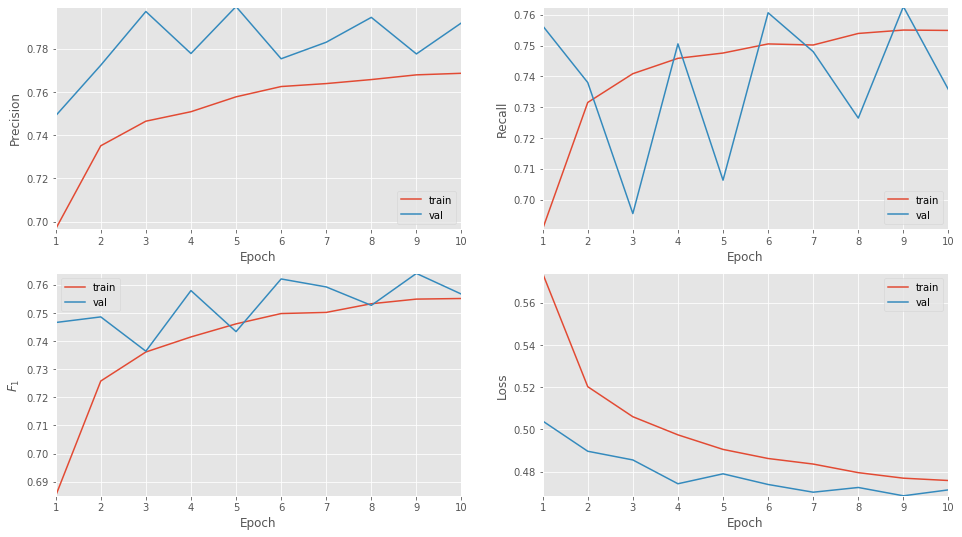

In [132]:
import matplotlib.pyplot as plt

plt.style.use('ggplot')


def plot_metrix(ax, x1, x2, title):
    ax.plot(range(1, len(x1) + 1), x1, label='train')
    ax.plot(range(1, len(x2) + 1), x2, label='val')
    ax.set_ylabel(title)
    ax.set_xlabel('Epoch')
    ax.legend()
    ax.margins(0)


def plot_history(history):
    fig, axes = plt.subplots(ncols=2, nrows=2, figsize=(16, 9))
    ax1, ax2, ax3, ax4 = axes.ravel()

    plot_metrix(ax1, history.history['precision'], history.history['val_precision'], 'Precision')
    plot_metrix(ax2, history.history['recall'], history.history['val_recall'], 'Recall')
    plot_metrix(ax3, history.history['f1'], history.history['val_f1'], "$F_1$")
    plot_metrix(ax4, history.history['loss'], history.history['val_loss'], 'Loss')

    plt.show()


plot_history(history)

In [133]:
from sklearn.metrics import classification_report

predicted = np.round(model.predict(x_test_seq))
print(classification_report(y_test, predicted, digits=5))

              precision    recall  f1-score   support

           0    0.75069   0.80772   0.77816     22457
           1    0.79046   0.73002   0.75904     22313

    accuracy                        0.76900     44770
   macro avg    0.77058   0.76887   0.76860     44770
weighted avg    0.77051   0.76900   0.76863     44770



In [134]:
from keras import optimizers

model.layers[1].trainable = True
adam = optimizers.Adam(lr=0.0001)
model.compile(loss='binary_crossentropy', optimizer=adam, metrics=[precision, recall, f1])
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 26)]         0                                            
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, 26, 200)      20000000    input_3[0][0]                    
__________________________________________________________________________________________________
dropout_5 (Dropout)             (None, 26, 200)      0           embedding_2[0][0]                
__________________________________________________________________________________________________
conv1d_83 (Conv1D)              (None, 25, 1)        401         dropout_5[0][0]                  
____________________________________________________________________________________________

In [135]:
checkpoint = ModelCheckpoint("models/cnn/cnn-trainable-{epoch:02d}-{val_f1:.2f}.hdf5", 
                             monitor='val_f1', save_best_only=True, mode='max', period=1)

history_trainable = model.fit(x_train_seq, y_train, batch_size=32, epochs=5, validation_split=0.25, callbacks = [checkpoint])

2021-03-10 15:17:32,719 : WARNING : `period` argument is deprecated. Please use `save_freq` to specify the frequency in number of batches seen.


Epoch 1/5
4198/4198 [==============================] - 654s 155ms/step - loss: 0.4643 - precision: 0.7755 - recall: 0.7646 - f1: 0.7642 - val_loss: 0.4615 - val_precision: 0.7861 - val_recall: 0.7543 - val_f1: 0.7643
Epoch 2/5
4198/4198 [==============================] - 638s 152ms/step - loss: 0.4543 - precision: 0.7812 - recall: 0.7714 - f1: 0.7702 - val_loss: 0.4586 - val_precision: 0.7954 - val_recall: 0.7462 - val_f1: 0.7642
Epoch 3/5
4198/4198 [==============================] - 647s 154ms/step - loss: 0.4477 - precision: 0.7865 - recall: 0.7760 - f1: 0.7756 - val_loss: 0.4562 - val_precision: 0.7944 - val_recall: 0.7504 - val_f1: 0.7659
Epoch 4/5
4198/4198 [==============================] - 673s 160ms/step - loss: 0.4431 - precision: 0.7923 - recall: 0.7806 - f1: 0.7807 - val_loss: 0.4550 - val_precision: 0.8000 - val_recall: 0.7444 - val_f1: 0.7651
Epoch 5/5
4198/4198 [==============================] - 664s 158ms/step - loss: 0.4362 - precision: 0.7920 - recall: 0.7803 - f1: 0.7

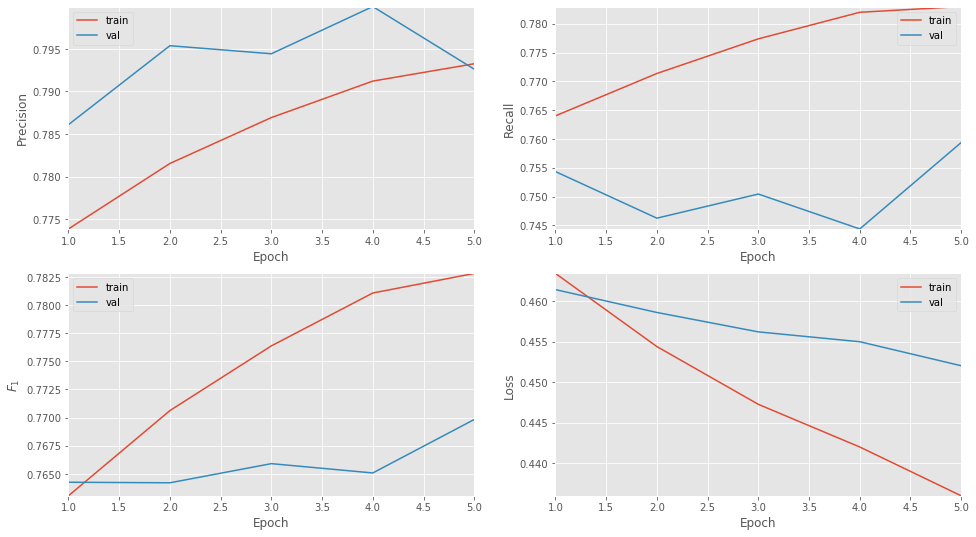

In [136]:
plot_history(history_trainable)

In [137]:
predicted = np.round(model.predict(x_test_seq))
print(classification_report(y_test, predicted, digits=5))

              precision    recall  f1-score   support

           0    0.76900   0.79988   0.78414     22457
           1    0.79011   0.75817   0.77381     22313

    accuracy                        0.77909     44770
   macro avg    0.77955   0.77903   0.77897     44770
weighted avg    0.77952   0.77909   0.77899     44770

